In [1]:
!pip install optproblems

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from math import sin, sqrt
from  optproblems import cec2005
from  optproblems import Individual
import statistics
from datetime import datetime

In [3]:
class Problem:
  def __init__(self,f):
    self.f = f
  
  def evaluate(self,sol):
      func =  self.f(len(sol))
      solution=Individual(sol)
      func.evaluate(solution)
      return solution.objective_values

  def optimal(self,length):
    func = self.f(length)
    solutions = func.get_optimal_solutions()
    for sol in solutions:
      func.evaluate(sol) # return single solution
      return sol.objective_values
    return 0

In [4]:
class Particle:
    """A particle consists of two parts:
          The particle’s location in space, ~x = hx1, x2, ...i. This is the equivalent, in evolutionary algorithms, of the individual’s genotype.
          The particle’s velocity, ~v = hv1, v2, ...i. This is the speed and direction at which the particle is traveling each timestep"""
    def __init__(self, bounds,w,c1,c2,num_variables):
        self.particle_velocity = []                     
        self.particle_position = []                     
        self.best_position = [] # particle best position        
        self.best_pos_fitness = float("inf") # initialize best position fitness 
        self.particle_pos_fitness = float("inf")
        self.num_variables = num_variables                 
        self.w=w
        self.c1=c1
        self.c2=c2

       
        for i in range(self.num_variables):
        #define random initial position and velocity
            self.particle_position.append(random.uniform(bounds[0],bounds[1]))
            self.particle_velocity.append(random.uniform(-1, 1))
    #Evalaute using Objective Funcations 
    def evaluate(self, objective_fun):
        self.particle_pos_fitness = objective_fun.evaluate(
            self.particle_position)
        
        if self.particle_pos_fitness < self.best_pos_fitness:
          #update best position and fitness
          self.best_position = self.particle_position
          self.best_pos_fitness = self.particle_pos_fitness

    def update_position(self, bounds):
        for i in range(self.num_variables):
            self.particle_position[i] = self.particle_position[i] + \
                self.particle_velocity[i]

            # checking with the upper bounds
            if self.particle_position[i] > bounds[1]:
                self.particle_position[i] = bounds[1]
            # checking with the lower bounds
            if self.particle_position[i] < bounds[0]:
                self.particle_position[i] = bounds[0]

    # update particles by cheinging their positions and velocity depending on information of best position and global best position
    """Velocity update
        At each iteration, velocity of a particle is changed according to four criteria
        1-	 Own best position so far (cognitive component): a coefficient (𝛽) is used to
             weight this component, usually called the cognitive weight
        2-	Informants’ best position (social component): a coefficient (𝛾) is used to
            weight this component, called the social weight
        3-	Global best position (part of social component): weighted by a coefficient (𝛿)
            called the global weight
        4-	An inertia principle by which we consider the previous velocity, using an
            inertia weight (𝛼)"""  
    def update_velocity(self, global_best_pos, fittest_informant):
        self.fittest_informant=fittest_informant
        for i in range(self.num_variables):
            r1 = random.random()
            r2 = random.random()

            cognitive_velocity = self.c1*r1 * \
                (self.best_position[i] -
                 self.particle_position[i])
            #update social velocity by informant fittest
            social_velocity = self.c2*r2 * \
                (fittest_informant.particle_position[i] - self.particle_position[i])
            globalVelocity=self.c2*r2 * \
                (global_best_pos[i] - self.particle_position[i])    
            self.particle_velocity[i] = self.w*self.particle_velocity[i] + \
                cognitive_velocity + social_velocity+globalVelocity

In [5]:
#Evaluate swarm and return the fittest particle based on previous position
def get_current_best(swarm, objective_fun):
    fitnesses = [assess_fitness(x.particle_position, objective_fun) for x in swarm]
    best_value = min(fitnesses)
    best_index = fitnesses.index(best_value)
    return swarm[best_index]

def assess_fitness(individual, objective_fun):
    "Determines the fitness of an individual using the given problem"
    return objective_fun.evaluate(individual)


In [6]:
class PSO():
    def __init__(self, objective_fun, bounds, num_particles, iterations,num_informants,w,c1,c2,num_variables):
        self.num_informants = num_informants #informants: set of particles with which a particle shares information
        self.global_best_fitness = float("inf")
        self.global_best_pos = []
        global_best_positions=[]
        swarm_particle = []
        self.history = []
        for i in range(num_particles):# Particle size= number of particles
            swarm_particle.append(Particle(bounds,w,c1,c2,num_variables))

        for i in range(iterations):
            for j in range(num_particles):
                swarm_particle[j].evaluate(objective_fun)
                
                if swarm_particle[j].particle_pos_fitness < self.global_best_fitness:
                  self.global_best_pos = list(swarm_particle[j].particle_position)
                  self.global_best_fitness = float(swarm_particle[j].particle_pos_fitness)
            self.history.append(self.global_best_fitness)

            ## iterate to assign particle informants and update the position and velocity for particle with gbest and ibest
            for j in range(num_particles):
                #informants find fittest
                informants = np.random.choice(swarm_particle, self.num_informants)
                if swarm_particle[j] not in informants:
                  np.append(informants, swarm_particle[j])
                  #find the best in swarm by informants    
                fittest_informant = get_current_best(informants, objective_fun)

                swarm_particle[j].update_velocity(self.global_best_pos, fittest_informant)
                swarm_particle[j].update_position(bounds)       
        
    def get_fittest_global_Pos(self):
      return self.global_best_pos
    def get_global_best_fitness(self):
      return self.global_best_fitness

# Evaluation & Experiments

In [7]:
f1 = Problem(cec2005.F1)
f2 = Problem(cec2005.F2)
f3 = Problem(cec2005.F3)
f4 = Problem(cec2005.F4)
f5 = Problem(cec2005.F5)
f6 = Problem(cec2005.F6)
f8 = Problem(cec2005.F8)

In [8]:
def run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS, NUM_PARTICLES, ITERATIONS, NUM_INFORMANTS,W,C1,C2,runs=50):
  ## Evaluation 
  evaluation = {
      'accuracies': [],
      'timedRuns': [],
      'runs': [],
  }
  for run in range(runs):
    print('RUN ',run+1)
    start_time = datetime.now()
    pso = PSO(OBJECTIVE_FUNC, BOUNDS, NUM_PARTICLES, ITERATIONS, NUM_INFORMANTS,W,C1,C2,VECTOR_LENGTH)
    score,solution=pso.get_global_best_fitness(), pso.get_fittest_global_Pos()
    delta_time = datetime.now() - start_time 
    timeTaken = delta_time.total_seconds() * 1000
    accuracy = (score / OBJECTIVE_FUNC.optimal(VECTOR_LENGTH)) * 100

    evaluation['timedRuns'].append(timeTaken)
    evaluation['accuracies'].append(accuracy)
    evaluation['runs'].append(pso.history)

    print('Time taken->',timeTaken, 'ms')
    print('Fittest individual->',solution)
    print('Accuracy ->',accuracy,'%')
    print('#####################################')
  return evaluation

In [9]:
## Experiments parameetrs 
experiment_runs = 25

## Experiment 1

### F1

In [10]:
## Running Experiment 1 for F1
## Hyperparameters
print('F1')
OBJECTIVE_FUNC=f1
VECTOR_LENGTH = 10
BOUNDS= (-100,100)
NUM_PARTICLES =50
ITERATIONS=30
NUM_INFORMANTS=2
W = 0.1  # inertia constant
C1 = 0.1   # cognative constant
C2 = 1    # social constant
exp_f1 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F1
RUN  1
Time taken-> 372.697 ms
Fittest individual-> [-39.263555463142694, 58.93300970037971, -46.37390952983018, -74.54914893044926, -16.820278702032688, -80.60297562912059, -10.64562703511144, 24.953445620865022, 89.84470564153906, 9.095177650414058]
Accuracy -> 99.99472368658215 %
#####################################
RUN  2
Time taken-> 419.293 ms
Fittest individual-> [-39.413145299803794, 58.837021197775854, -46.37087769895834, -74.59659556753054, -16.90577724314611, -81.45600773950173, -10.491499667941962, 24.992112153851956, 89.85333715972612, 9.11638013628568]
Accuracy -> 99.80587552324143 %
#####################################
RUN  3
Time taken-> 525.7180000000001 ms
Fittest individual-> [-38.77796180091883, 58.95691326095799, -46.24433679050134, -74.76741687560023, -16.999995207259904, -80.43291691182235, -10.566586119781372, 24.91749685045181, 89.86202277102373, 8.949664420183419]
Accuracy -> 99.91318940871379 %
#####################################
RUN  4
Time taken-> 36

### F4

In [11]:
## Running Experiment 1 for F4
## Hyperparameters
print('F4')
OBJECTIVE_FUNC=f4
VECTOR_LENGTH = 10
BOUNDS= (-100,100)
NUM_PARTICLES =150
ITERATIONS=50
NUM_INFORMANTS=10
W = 0.1  # inertia constant
C1 = 0.1   # cognative constant
C2 = 1    # social constant
exp_f4 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F4
RUN  1
Time taken-> 5128.829 ms
Fittest individual-> [34.22857007774971, -80.83796333787643, -8.555037984774962, -95.96823555234947, 99.93507782020825, 37.44910763739126, -84.14030712032108, -30.012222651732714, 74.76837859449635, -38.01648321063693]
Accuracy -> 62.37908886903774 %
#####################################
RUN  2
Time taken-> 11268.337000000001 ms
Fittest individual-> [35.71397275728241, -82.26866836003919, -12.615996033963993, -81.35291558890623, 81.6168409340773, 47.09419792269931, -87.25382950260891, -26.01428531500083, 69.80946722654161, -36.24290381781624]
Accuracy -> 94.04686044294172 %
#####################################
RUN  3
Time taken-> 9970.7 ms
Fittest individual-> [43.15441456645774, -96.83970081437191, 1.1182118800819496, -94.73572086556936, 92.52177705047056, 41.43390231477702, -85.36860477343332, -30.798302112571882, 79.89934613029473, -42.089303906300024]
Accuracy -> 58.00677097867803 %
#####################################
RUN  4
Time taken-> 4376.4

### F8

In [12]:
## Running Experiment 1 for F8
## Hyperparameters
print('F8')
OBJECTIVE_FUNC=f8
VECTOR_LENGTH = 10
BOUNDS= (-32,32)
NUM_PARTICLES =10
ITERATIONS=10
NUM_INFORMANTS=2
W = 0.2  # inertia constant
C1 = 0.1   # cognative constant
C2 = 0.2    # social constant
exp_f8 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F8
RUN  1
Time taken-> 39.752 ms
Fittest individual-> [0.7414636932160037, -0.16513397465615354, 0.5779066921732352, -22.85475705831077, 6.7450897913251175, 11.59921678286445, -16.165582829975275, 19.787691581732258, -7.448105072088645, 13.742709662895777]
Accuracy -> 84.9748291842952 %
#####################################
RUN  2
Time taken-> 35.95099999999999 ms
Fittest individual-> [5.015749657261434, -5.678310695713338, -5.228317222727565, 10.199963569970741, -18.2496364104499, -18.434008524433374, -22.066779923143454, -3.4922592685934393, -0.28434453937054577, -11.145340545479375]
Accuracy -> 85.17985250761737 %
#####################################
RUN  3
Time taken-> 35.11 ms
Fittest individual-> [-0.11560859060899897, 8.3462775666442, -7.81257665024719, 6.524441849431142, 4.524234476708953, -14.505939680311233, 1.622603916765966, 3.1952476718057277, -0.5917545980710062, 6.560974169056458]
Accuracy -> 84.98467303031228 %
#####################################
RUN  4
Time taken-> 

## Analysis

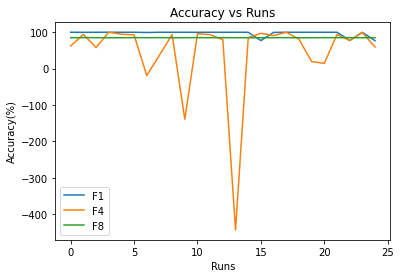

In [13]:
## Compare F1,F4,F8 Accuracy
x_axis = [i for i in range(experiment_runs)]
plt.plot(x_axis, exp_f1['accuracies'])
plt.plot(x_axis, exp_f4['accuracies'])
plt.plot(x_axis, exp_f8['accuracies'])

plt.title('Accuracy vs Runs')
plt.xlabel('Runs')
plt.ylabel('Accuracy(%)')
plt.legend(['F1', 'F4','F8'])
plt.show()

### F1

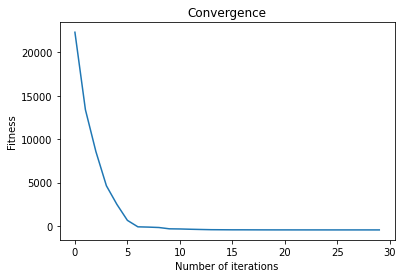

In [14]:
## F1 Convergence Single Run
x_axis = [i for i in range(len(exp_f1['runs'][0]))]
plt.plot(x_axis, exp_f1['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F4

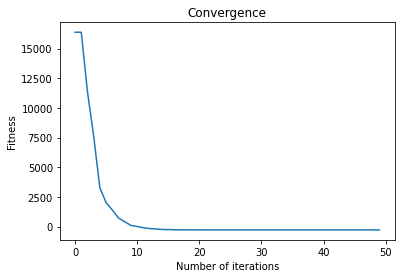

In [15]:
## F4 Convergence Single Run
x_axis = [i for i in range(len(exp_f4['runs'][0]))]
plt.plot(x_axis, exp_f4['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F8

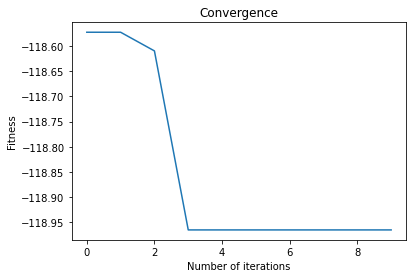

In [16]:
## F8 Convergence Single Run
x_axis = [i for i in range(len(exp_f8['runs'][0]))]
plt.plot(x_axis, exp_f8['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

In [17]:
best_exp_f1 = np.max(exp_f1['accuracies'])
print('Best F1 Accuracy->',best_exp_f1)
best_exp_f4 = np.max(exp_f4['accuracies'])
print('Best F4 Accuracy->',best_exp_f4)
best_exp_f8 = np.max(exp_f8['accuracies'])
print('Best F8 Accuracy->',best_exp_f8)

Best F1 Accuracy-> 99.99923270897777
Best F4 Accuracy-> 99.9931621130439
Best F8 Accuracy-> 85.19250046885993


In [18]:
worst_exp_f1 = np.min(exp_f1['accuracies'])
print('Worst F1 Accuracy->',worst_exp_f1)
worst_exp_f4 = np.min(exp_f4['accuracies'])
print('Worst F4 Accuracy->',worst_exp_f4)
worst_exp_f8 = np.min(exp_f8['accuracies'])
print('Worst F8 Accuracy->',worst_exp_f8)

Worst F1 Accuracy-> 76.70760753422495
Worst F4 Accuracy-> -443.49406273689755
Worst F8 Accuracy-> 84.83609177296375


In [19]:
median_exp_f1 = np.median(exp_f1['accuracies'])
print('median F1 Accuracy->',median_exp_f1)
median_exp_f4 = np.median(exp_f4['accuracies'])
print('median F4 Accuracy->',median_exp_f4)
median_exp_f8 = np.median(exp_f8['accuracies'])
print('median F8 Accuracy->',median_exp_f8)

median F1 Accuracy-> 99.9300235473201
median F4 Accuracy-> 84.81563124395565
median F8 Accuracy-> 84.98026273495664


In [20]:
from statistics import mean 
t1 = mean(exp_f1['timedRuns'])
t4 =  mean(exp_f4['timedRuns'])
t8 =  mean(exp_f8['timedRuns'])
print(t1,t4,t8)

502.3042 5052.7664 37.357


In [21]:
reliability_exp_f1 = mean(exp_f1['accuracies'])
accuracy_exp_f1 = mean(exp_f1['accuracies'][0:20])
efficiency_exp_f1 = mean(exp_f1['timedRuns'])

print("Reliability",reliability_exp_f1)
print("Accuracy",accuracy_exp_f1)
print("Efficiency",efficiency_exp_f1)

Reliability 97.15072062113802
Accuracy 98.75955444692738
Efficiency 502.3042


In [22]:
reliability_exp_f4 = mean(exp_f4['accuracies'])
accuracy_exp_f4 = mean(exp_f4['accuracies'][0:20])
efficiency_exp_f4 = mean(exp_f4['timedRuns'])

print("Reliability",reliability_exp_f4)
print("Accuracy",accuracy_exp_f4)
print("Efficiency",efficiency_exp_f4)

Reliability 44.69882462219997
Accuracy 38.63674774507583
Efficiency 5052.7664


In [23]:
reliability_exp_f8 = mean(exp_f8['accuracies'])
accuracy_exp_f8 = mean(exp_f8['accuracies'][0:20])
efficiency_exp_f8 = mean(exp_f8['timedRuns'])

print("Reliability",reliability_exp_f8)
print("Accuracy",accuracy_exp_f8)
print("Efficiency",efficiency_exp_f8)

Reliability 85.00608714632948
Accuracy 84.99969833455413
Efficiency 37.357


## Experiment 2

### F1

In [24]:
## Running Experiment F1
## Hyperparameters
print('F1')
OBJECTIVE_FUNC=f1
VECTOR_LENGTH = 10
BOUNDS= (-100,100)
NUM_PARTICLES =100
ITERATIONS=50
NUM_INFORMANTS=2
W = 0.1  # inertia constant
C1 = 0.1   # cognative constant
C2 = 1    # social constant
exp_f1 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F1
RUN  1
Time taken-> 1592.4270000000001 ms
Fittest individual-> [-39.31168686651435, 58.899776295256565, -46.32252599315081, -74.65189640897033, -16.79948574457866, -80.54424339792071, -10.593104171619295, 24.968974667346796, 89.83858485627843, 9.112043287267074]
Accuracy -> 99.99999984611055 %
#####################################
RUN  2
Time taken-> 1607.116 ms
Fittest individual-> [-39.31190708363487, 58.899906246435876, -46.322365465623115, -74.65151813668284, -16.79973181302789, -80.5440948186807, -10.593485234281344, 24.969412990832215, 89.83839254859782, 9.111903469398984]
Accuracy -> 99.9999999993102 %
#####################################
RUN  3
Time taken-> 1596.06 ms
Fittest individual-> [-39.3118946527735, 58.899926111925396, -46.32238688082779, -74.65149962352282, -16.799788484834856, -80.5441134598417, -10.593450637098151, 24.969463371629136, 89.83837635348674, 9.11181413997136]
Accuracy -> 99.9999999948273 %
#####################################
RUN  4
Time taken-> 158

### F4

In [25]:
## Running Experiment F4
## Hyperparameters
print('F4')
OBJECTIVE_FUNC=f4
VECTOR_LENGTH = 10
BOUNDS= (-100,100)
NUM_PARTICLES =400
ITERATIONS=30
NUM_INFORMANTS=20
W = 0.1  # inertia constant
C1 = 0.1   # cognative constant
C2 = 1    # social constant
exp_f4 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F4
RUN  1
Time taken-> 13787.626 ms
Fittest individual-> [35.8521463412404, -83.40280770929608, -10.285746273351867, -83.84617581039672, 83.45024900559876, 46.863479946699464, -89.3129424581939, -27.54478140183817, 76.16818005474668, -39.05508347484456]
Accuracy -> 99.95744632217921 %
#####################################
RUN  2
Time taken-> 13639.366 ms
Fittest individual-> [35.604664278196985, -82.87973493214264, -10.641836166308032, -83.606780897697, 83.32076768823597, 46.76255431122189, -89.29801425425067, -27.5132883656051, 76.2498432608139, -39.168953339081405]
Accuracy -> 99.98696409375822 %
#####################################
RUN  3
Time taken-> 13743.771999999999 ms
Fittest individual-> [35.65683121343811, -82.87290344271068, -10.725960015277044, -83.56609462784063, 83.13777803693878, 47.04331491214133, -89.39211236641965, -27.396714883368332, 76.10051464613689, -39.06300344011717]
Accuracy -> 99.99782445019339 %
#####################################
RUN  4
Time taken-> 1426

### F8

In [26]:
## Running Experiment F8
## Hyperparameters
print('F8')
OBJECTIVE_FUNC=f8
VECTOR_LENGTH = 10
BOUNDS= (-32,32)
NUM_PARTICLES =20
ITERATIONS=10
NUM_INFORMANTS=2
W = 0.1  # inertia constant
C1 = 0.1   # cognative constant
C2 = 1    # social constant
exp_f8 = run_experiment(OBJECTIVE_FUNC,VECTOR_LENGTH,BOUNDS,NUM_PARTICLES,ITERATIONS,NUM_INFORMANTS,W,C1,C2,experiment_runs)

F8
RUN  1
Time taken-> 54.137 ms
Fittest individual-> [3.7008622919967067, 16.835265342382556, -30.41646390663736, -26.214455214877596, 22.423556160583253, 27.69543781897093, 17.245557108363073, -25.36345673740351, -6.098897041008129, -11.849796212679173]
Accuracy -> 84.96540871243033 %
#####################################
RUN  2
Time taken-> 54.019 ms
Fittest individual-> [24.475021533937195, 7.645319539914247, -13.960634354498236, 7.4195066872248585, -1.3118764248243906, -24.727549404668395, 7.720137764541729, 23.810241110057582, -20.66859624583244, 11.968743132224027]
Accuracy -> 85.11960257738875 %
#####################################
RUN  3
Time taken-> 74.764 ms
Fittest individual-> [3.7627900065124154, -8.373118513340746, 27.96844716338668, 15.581542340510472, -21.399322143765293, 2.2573494524931172, -10.508455975807383, -15.982648442827722, 8.590791619050956, -9.450336317835728]
Accuracy -> 85.05183317483566 %
#####################################
RUN  4
Time taken-> 57.276 m

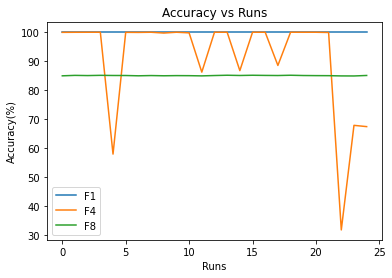

In [27]:
## Compare F1,F4,F8 Accuracy

x_axis = [i for i in range(experiment_runs)]
plt.plot(x_axis, exp_f1['accuracies'])
plt.plot(x_axis, exp_f4['accuracies'])
plt.plot(x_axis, exp_f8['accuracies'])

plt.title('Accuracy vs Runs')
plt.xlabel('Runs')
plt.ylabel('Accuracy(%)')
plt.legend(['F1', 'F4','F8'])
plt.show()

## Analysis

### F1

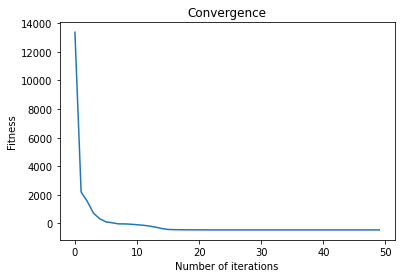

In [28]:
## F1 Convergence Single Run
x_axis = [i for i in range(len(exp_f1['runs'][0]))]
plt.plot(x_axis, exp_f1['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F4

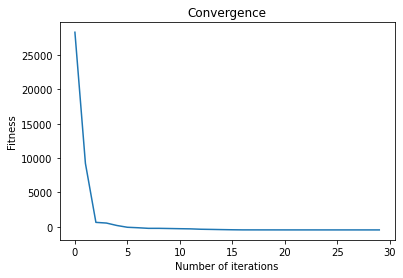

In [29]:
## F4 Convergence Single Run
x_axis = [i for i in range(len(exp_f4['runs'][0]))]
plt.plot(x_axis, exp_f4['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

### F8

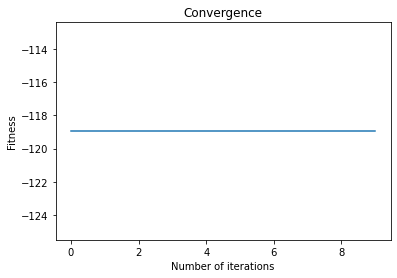

In [30]:
## F8 Convergence Single Run
x_axis = [i for i in range(len(exp_f8['runs'][0]))]
plt.plot(x_axis, exp_f8['runs'][0])
plt.title('Convergence')
plt.xlabel('Number of iterations')
plt.ylabel('Fitness')
plt.show()

In [31]:
best_exp_f1 = np.max(exp_f1['accuracies'])
print('Best F1 Accuracy->',best_exp_f1)
best_exp_f4 = np.max(exp_f4['accuracies'])
print('Best F4 Accuracy->',best_exp_f4)
best_exp_f8 = np.max(exp_f8['accuracies'])
print('Best F8 Accuracy->',best_exp_f8)

Best F1 Accuracy-> 99.9999999993102
Best F4 Accuracy-> 99.99997162613562
Best F8 Accuracy-> 85.16618581779257


In [32]:
worst_exp_f1 = np.min(exp_f1['accuracies'])
print('Worst F1 Accuracy->',worst_exp_f1)
worst_exp_f4 = np.min(exp_f4['accuracies'])
print('Worst F4 Accuracy->',worst_exp_f4)
worst_exp_f8 = np.min(exp_f8['accuracies'])
print('Worst F8 Accuracy->',worst_exp_f8)

Worst F1 Accuracy-> 99.99999973119384
Worst F4 Accuracy-> 31.802629287423457
Worst F8 Accuracy-> 84.91602464363443


In [33]:
median_exp_f1 = np.median(exp_f1['accuracies'])
print('median F1 Accuracy->',median_exp_f1)
median_exp_f4 = np.median(exp_f4['accuracies'])
print('median F4 Accuracy->',median_exp_f4)
median_exp_f8 = np.median(exp_f8['accuracies'])
print('median F8 Accuracy->',median_exp_f8)

median F1 Accuracy-> 99.99999999297162
median F4 Accuracy-> 99.96530202138683
median F8 Accuracy-> 85.06633925242805


In [34]:
from statistics import mean 

t1 = mean(exp_f1['timedRuns'])
t4 =  mean(exp_f4['timedRuns'])
t8 =  mean(exp_f8['timedRuns'])

print(t1,t4,t8)

1561.36616 13833.7596 70.11928


In [35]:
reliability_exp2_f1 = mean(exp_f1['accuracies'])
accuracy_exp2_f1 = mean(exp_f1['accuracies'][0:20])
efficiency_exp2_f1 = mean(exp_f1['timedRuns'])

print("Reliability",reliability_exp2_f1)
print("Accuracy",accuracy_exp2_f1)
print("Efficiency",efficiency_exp2_f1)

Reliability 99.99999997069449
Accuracy 99.99999996838575
Efficiency 1561.36616


In [36]:
reliability_exp2_f4 = mean(exp_f4['accuracies'])
accuracy_exp2_f4 = mean(exp_f4['accuracies'][0:20])
efficiency_exp2_f4 = mean(exp_f4['timedRuns'])

print("Reliability",reliability_exp2_f4)
print("Accuracy",accuracy_exp2_f4)
print("Efficiency",efficiency_exp2_f4)

Reliability 91.43582825026775
Accuracy 95.9428973348612
Efficiency 13833.7596


In [37]:
reliability_exp2_f8 = mean(exp_f8['accuracies'])
accuracy_exp2_f8 = mean(exp_f8['accuracies'][0:20])
efficiency_exp2_f8 = mean(exp_f8['timedRuns'])

print("Reliability",reliability_exp2_f8)
print("Accuracy",accuracy_exp2_f8)
print("Efficiency",efficiency_exp2_f8)

Reliability 85.05279311760607
Accuracy 85.0663215072562
Efficiency 70.11928
